In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import InputLayer, Activation, Add, Dense, Conv2D, GlobalAveragePooling2D, MaxPool2D,MaxPooling2D
from keras.layers import BatchNormalization, Dropout, Flatten
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Model
from keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix

2024-05-28 14:05:11.408057: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 14:05:11.408214: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 14:05:11.553628: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_data='/kaggle/input/waste-segregation-private-use/Datasets/Train'
val_data='/kaggle/input/waste-segregation-private-use/Datasets/Val'

In [3]:
# Define the path where our dataset is stored
dataset_path = '/kaggle/input/waste-classification-data-v2/DATASET/TRAIN'

# Retrieve the names of all folders (representing trash types) within the dataset directory
garbage_types = os.listdir(dataset_path)

# Set to store unique image dimensions for the entire dataset
all_dimensions_set = set()

# Iterate over each trash type (folder) to process images
for garbage_type in garbage_types:
    folder_path = os.path.join(dataset_path, garbage_type)
    
    # Verify that the current item is a directory
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg'))]
        
        # Display the count of images in the current folder
        num_images = len(image_files)
        print(f"{garbage_type} folder contains {num_images} images.")
        
        # Loop over each image to check its dimensions
        for image_file in image_files:
            image_path = os.path.join(folder_path, image_file)
            with Image.open(image_path) as img:
                # Extract the width, height, and channels (color depth) of the image and add to the dimensions set
                width, height = img.size
                channels = len(img.getbands())
                all_dimensions_set.add((width, height, channels))
                
# Determine if all images in the entore dataset have the same dimensions 
if len(all_dimensions_set) == 1: 
    width, height, channel = all_dimensions_set.pop()
    print(f"\nAll images in the dataset have the same dimensions: {width}x{height} with {channels} color channels.")
else:
    print("\nThe images in the dataset have different dimensions or color channels.")

N folder contains 2847 images.
R folder contains 7152 images.
O folder contains 12565 images.

The images in the dataset have different dimensions or color channels.


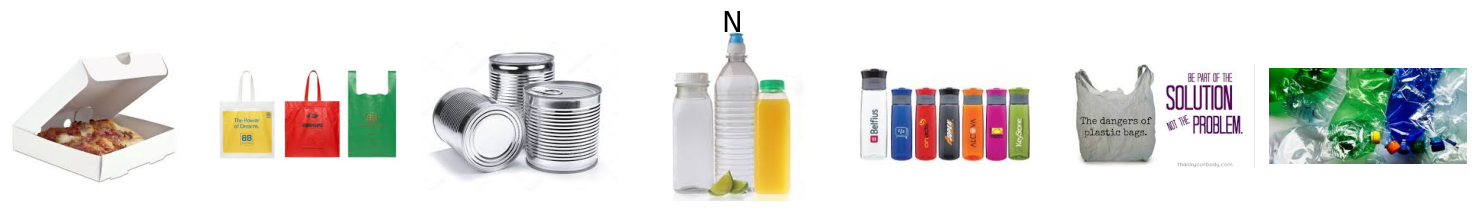

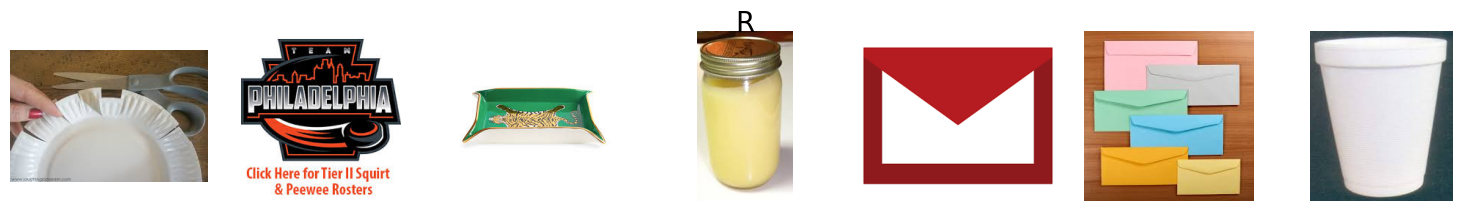

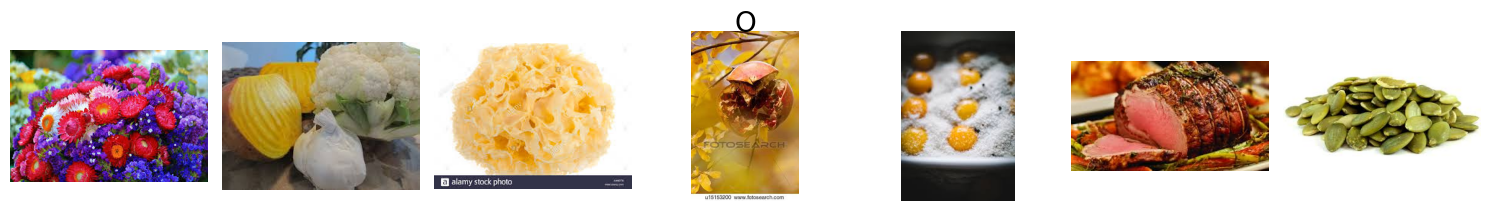

In [4]:
# Iterate over each trash type (folder) to display images
for garbage_type in garbage_types:
    folder_path = os.path.join(dataset_path, garbage_type)
    
    # Verify that the current item is a directory
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg'))]
        
        # Select the first 10 images
        image_files = image_files[:7]
        
        # Set up subplots
        fig, axs = plt.subplots(1, 7, figsize=(15, 2))
        
        for i, image_file in enumerate(image_files):
            image_path = os.path.join(folder_path, image_file)
            with Image.open(image_path) as img:
                axs[i].imshow(img)
                axs[i].axis('off')
        
        plt.tight_layout()
        fig.suptitle(garbage_type, fontsize=20, y=1.03)
        plt.show()

In [5]:
# Initialize an empty list to store image file paths and their respective labels
data = []

# Loop through each garbage type and collect its images' file paths
for garbage_type in garbage_types:
    for file in os.listdir(os.path.join(dataset_path, garbage_type)):
        # Append the image file path and its trash type (as a label) to the data list
        data.append((os.path.join(dataset_path, garbage_type, file), garbage_type))

# Convert the collected data into a DataFrame
df = pd.DataFrame(data, columns=['filepath', 'label'])

# Display the first few entries of the DataFrame
df.head()

,filepath,label
0,/kaggle/input/waste-classification-data-v2/DAT...,N
1,/kaggle/input/waste-classification-data-v2/DAT...,N
2,/kaggle/input/waste-classification-data-v2/DAT...,N
3,/kaggle/input/waste-classification-data-v2/DAT...,N
4,/kaggle/input/waste-classification-data-v2/DAT...,N


In [6]:
# Split with stratification
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# Print the number of images in each set
print(f"Number of images in the training set: {len(train_df)}")
print(f"Number of images in the validation set: {len(val_df)}")

Number of images in the training set: 18051
Number of images in the validation set: 4513


In [7]:
# Slight Augmentation settings for training
train_datagen = ImageDataGenerator(
    rescale=1./255,                     # Normalize pixel values to [0,1]
    rotation_range=45,                  # Randomly rotate the images by up to 45 degrees
    #width_shift_range=0.15,             # Randomly shift images horizontally by up to 15% of the width
    #height_shift_range=0.15,            # Randomly shift images vertically by up to 15% of the height
    #zoom_range=0.15,                    # Randomly zoom in or out by up to 15%
    #horizontal_flip=True,               # Randomly flip images horizontally
    #vertical_flip=True,                 # Randomly flip images vertically
    #shear_range=0.05,                   # Apply slight shear transformations
    #brightness_range=[0.9, 1.1],        # Vary brightness between 90% to 110% of original
    #channel_shift_range=10,             # Randomly shift channels (can change colors of images slightly but less aggressively)
    fill_mode='nearest',                 # Fill in missing pixels using the nearest filled value
    validation_split=0.2
)

# Only rescaling for validation
test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224,224),              # Resize all images to size of 384x384
    batch_size=64,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False,                        # Data is not shuffled; order retained from DataFrame
    subset='training'
)


# Generate validation batches from the validation dataframe
val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224,224),              # Resize all images to size of 384x384
    batch_size=64,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False,                        # Data is not shuffled; order retained from DataFrame
    subset='validation'
)

Found 18052 images belonging to 3 classes.
Found 4512 images belonging to 3 classes.


In [9]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, Lambda
from tensorflow.keras.models import Model
#in_lay = Input((384,384,3))
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))
#res = ResNet152V2(include_top=False, weights='imagenet', input_shape=(224,224,3))
for layer in vgg.layers:
    layer.trainable=False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
x = Flatten()(vgg.output)
prediction = Dense(3,activation='softmax')(x)
model_1 = Model(inputs=vgg.input, outputs=prediction)
model_1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │        75,267 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,789,955 (56.42 MB)

 Trainable params: 75,267 (294.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [11]:
from keras.metrics import top_k_categorical_accuracy
from keras.losses import categorical_crossentropy, binary_crossentropy
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
callbacks = EarlyStopping(patience = 5, monitor='val_accuracy', mode='max')
#reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=10, min_lr=0.00001)

# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath='vgg_model.keras',
#     save_weights_only=False,
#     monitor='loss',
#     save_best_only=True,
#     mode='max')

#run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)

model_1.compile(optimizer = Adam(learning_rate=0.0001), 
                   loss = 'categorical_crossentropy',
                   metrics = ['accuracy'])

In [12]:
# from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
# weight_path="{}_best.weights.h5".format('wastes')

# checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
#                              save_best_only=True, mode='min', save_weights_only = True)

# reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=1, mode='auto', epsilon=0.000001, cooldown=5, min_lr=0.000001)
# early = EarlyStopping(monitor="val_loss", 
#                       mode="min", 
#                       patience=6) # probably needs to be more patient, but kaggle time is limited
# callbacks_list = [checkpoint, early, reduceLROnPlat]

In [13]:
history=model_1.fit(train_generator, 
                           steps_per_epoch = train_df.shape[0], #train_df.shape[0]//batch_size,
                           validation_data = val_generator, 
                           validation_steps = val_df.shape[0], #valid_df.shape[0]//batch_size,
                              epochs = 20, 
                              callbacks = [callbacks],
                            )

Epoch 1/20


2024-05-28 14:07:33.217134: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[64,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-05-28 14:07:33.651773: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100352: 3.87759, expected 3.06898
2024-05-28 14:07:33.651831: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100353: 6.47516, expected 5.66656
2024-05-28 14:07:33.651840: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100354: 6.23991, expected 5.43131
2024-05-28 14:07:33.651848: E external/local_xla/xla/service/gpu/buffer_compar

    1/18051 ━━━━━━━━━━━━━━━━━━━━ 194:46:52 39s/step - accuracy: 0.0156 - loss: 2.0386

I0000 00:00:1716905283.127391      86 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716905283.149494      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  245/18051 ━━━━━━━━━━━━━━━━━━━━ 3:28:45 703ms/step - accuracy: 0.6016 - loss: 0.9520

2024-05-28 14:10:55.821307: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.46848, expected 3.68847
2024-05-28 14:10:55.821365: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 6.72762, expected 5.94762
2024-05-28 14:10:55.821385: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.00592, expected 5.22591
2024-05-28 14:10:55.821399: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.42362, expected 5.64362
2024-05-28 14:10:55.821410: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.34585, expected 4.56585
2024-05-28 14:10:55.821420: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 5.68756, expected 4.90755
2024-05-28 14:10:55.821431: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 5.73264, expected 4.95264
2024-05-28 14:10:55.821442: E external/local_xla/xla/se

  283/18051 ━━━━━━━━━━━━━━━━━━━━ 3:27:16 700ms/step - accuracy: 0.6100 - loss: 0.9346

2024-05-28 14:12:12.250153: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.63498, expected 3.85968
2024-05-28 14:12:12.250225: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.55784, expected 5.78254
2024-05-28 14:12:12.250254: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.61282, expected 5.83752
2024-05-28 14:12:12.250269: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.34499, expected 5.56968
2024-05-28 14:12:12.250280: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.25159, expected 5.47629
2024-05-28 14:12:12.250290: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 5.43964, expected 4.66434
2024-05-28 14:12:12.250301: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 6.54333, expected 5.76803
2024-05-28 14:12:12.250311: E external/local_xla/xla/se

18051/18051 ━━━━━━━━━━━━━━━━━━━━ 303s 15ms/step - accuracy: 0.6677 - loss: 0.8188 - val_accuracy: 0.7939 - val_loss: 0.5744
Epoch 2/20
18051/18051 ━━━━━━━━━━━━━━━━━━━━ 241s 13ms/step - accuracy: 0.7285 - loss: 0.6793 - val_accuracy: 0.7706 - val_loss: 0.5883
Epoch 3/20
18051/18051 ━━━━━━━━━━━━━━━━━━━━ 241s 13ms/step - accuracy: 0.7724 - loss: 0.5731 - val_accuracy: 0.7529 - val_loss: 0.5855
Epoch 4/20
18051/18051 ━━━━━━━━━━━━━━━━━━━━ 245s 13ms/step - accuracy: 0.7651 - loss: 0.5845 - val_accuracy: 0.7870 - val_loss: 0.5282
Epoch 5/20
18051/18051 ━━━━━━━━━━━━━━━━━━━━ 250s 14ms/step - accuracy: 0.7840 - loss: 0.5512 - val_accuracy: 0.7360 - val_loss: 0.6801
Epoch 6/20
18051/18051 ━━━━━━━━━━━━━━━━━━━━ 252s 14ms/step - accuracy: 0.7941 - loss: 0.5087 - val_accuracy: 0.7970 - val_loss: 0.5387
Epoch 7/20
18051/18051 ━━━━━━━━━━━━━━━━━━━━ 251s 14ms/step - accuracy: 0.8072 - loss: 0.4898 - val_accuracy: 0.7879 - val_loss: 0.5183
Epoch 8/20
18051/18051 ━━━━━━━━━━━━━━━━━━━━ 252s 14ms/step - accur

In [14]:
def plot_history(history):
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    plt.figure(2)
    epochs=range(1,len(history.history[acc_list[0]]) + 1)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

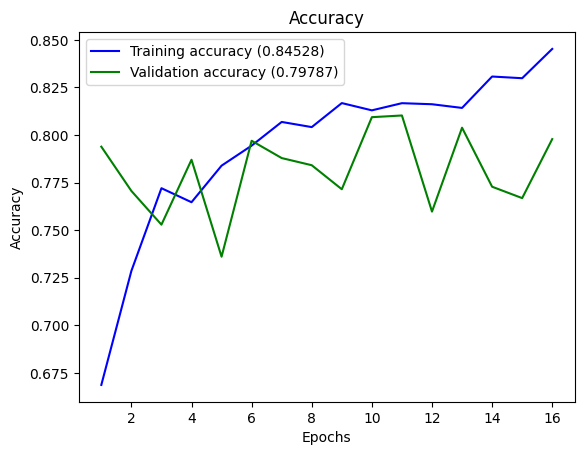

In [15]:
plot_history(history)